In [16]:
import pandas as pd
import geopandas as gpd
import osmnx as osm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pyproj import Transformer
from shapely.geometry import *
import networkx as nx

In [27]:
# import all the data
trip_data = pd.read_csv('../Data/02_Processed_Data/cleaned_trip_data.csv')
trip_data['Start date'] = pd.to_datetime(trip_data['Start date'])
trip_data['End date'] = pd.to_datetime(trip_data['End date'])
station_data = pd.read_csv('../Data/02_Processed_Data/cleaned_station_data.csv')
station_data = gpd.GeoDataFrame(station_data, geometry=gpd.points_from_xy(station_data['lon'], station_data['lat'], crs='epsg:4326'))
station_data = osm.project_gdf(station_data)
central_london = osm.io.load_graphml('../Data/02_Processed_Data/Central_london.osm')

In [11]:
# add the longitude and latitude of the start and end stations
trip_data = trip_data.merge(station_data[['commonName', 'lat', 'lon']], left_on='Start station', right_on='commonName', suffixes=('', '_start'))
trip_data = trip_data.merge(station_data[['commonName', 'lat', 'lon']], left_on='End station', right_on='commonName', suffixes=('', '_end'))
# drop the commonName columns
trip_data.drop(columns=['commonName', 'commonName_end'], inplace=True)
# rename the lat and lon column to lat_start, lon_start
trip_data.rename(columns={'lat': 'lat_start', 'lon': 'lon_start'}, inplace=True)

In [15]:
# Get the CRS of the projected graph
crs_proj = central_london.graph['crs']

# Create a transformer to convert lat/lon to the projected CRS
transformer = Transformer.from_crs("epsg:4326", crs_proj, always_xy=True)

# 2) Data Exploration

In this Notebook we will explore the data that we cleaned in the previous notebook. 

We will look at the following:
1) Heatmap of the most frequently travelled streets
2) Heatmap of the most requently visited bicycle stations


## (01) Heatmap of the most frequently travelled streets

In [21]:
num_od_pairs = 10

london_OD_paths_in_Network = trip_data.tail(num_od_pairs)

# Initialize the lists for 'od_paths_arc_infos' and 'od_paths'
q_list = []
n_list = []
a_list = []
d_list = []  # distance of an arc
counter = 0
# Iterate over the OD pairs
for index, row in london_OD_paths_in_Network.iterrows():
    print(f"Processing OD pair {counter}")
    # Find the nearest nodes in the graph to these points
    # Transform the coordinates to the projected CRS
    lon_proj, lat_proj = transformer.transform(row['lon_start'], row['lat_start'])
    lon_end_proj, lat_end_proj = transformer.transform(row['lon_end'], row['lat_end'])
    origin_node = osm.nearest_nodes(central_london,lon_proj, lat_proj)
    destination_node = osm.nearest_nodes(central_london, lon_end_proj, lat_end_proj)

    # Compute the shortest path
    try:
        path = osm.shortest_path(central_london, origin_node, destination_node, weight='length')
        print(path)
        arc_distances = []
        arcs = []

        if path is not None:
            # Calculate distances for each arc
            for i in range(len(path) - 1):
                arc = (path[i], path[i + 1])
                arcs.append(arc)
                distance = nx.shortest_path_length(central_london, arc[0], arc[1], weight="length")
                arc_distances.append(distance)

        q_list.append(index)
        n_list.append(path)
        a_list.append(arcs)
        d_list.append(arc_distances)
    except nx.NetworkXNoPath:
        print(f"No path found for OD pair at index {index}")
    
    counter += 1

# Create 'od_paths'
od_paths = pd.DataFrame({'q': q_list, 'N': n_list, 'A': a_list})

Processing OD pair 0
[10996221107, 10996221108, 294651409, 294651404, 10365728, 3442281747, 1215418697, 1316072128, 234290, 6897120915, 1215418493, 23044196, 6311920513, 293810498, 106213, 8908418097, 9498441991, 168777, 1317156154, 293810496, 2177834978, 200054, 34708778, 2095079012, 7198096092, 25495417, 25522558, 2414118569, 821550, 821559, 7081430685, 5560625853, 5832638564, 1694551560, 1685938656, 822403, 102000, 311422343, 102005, 107343, 591983290, 2450783574, 369977345, 1154267425, 1685751704, 25496592, 1684410094, 1684410087, 9046520718, 25472258, 2198870632, 107333, 3693305990, 2047806082, 2198870634, 3246859596, 11307985186, 11307985203, 11307985199, 6250340159, 2480891600, 11307985196, 4347805231, 11307985193, 2047806133, 6250401311, 11308044775, 11307995867, 11308044776, 11308044774, 11308044788, 11308044787]
Processing OD pair 1
[412849561, 1853160950, 2986424078, 2568119473, 2986402100, 2568119476, 10512501, 1034393420, 108468, 108467, 5650663958, 5933049455, 10512503, 5

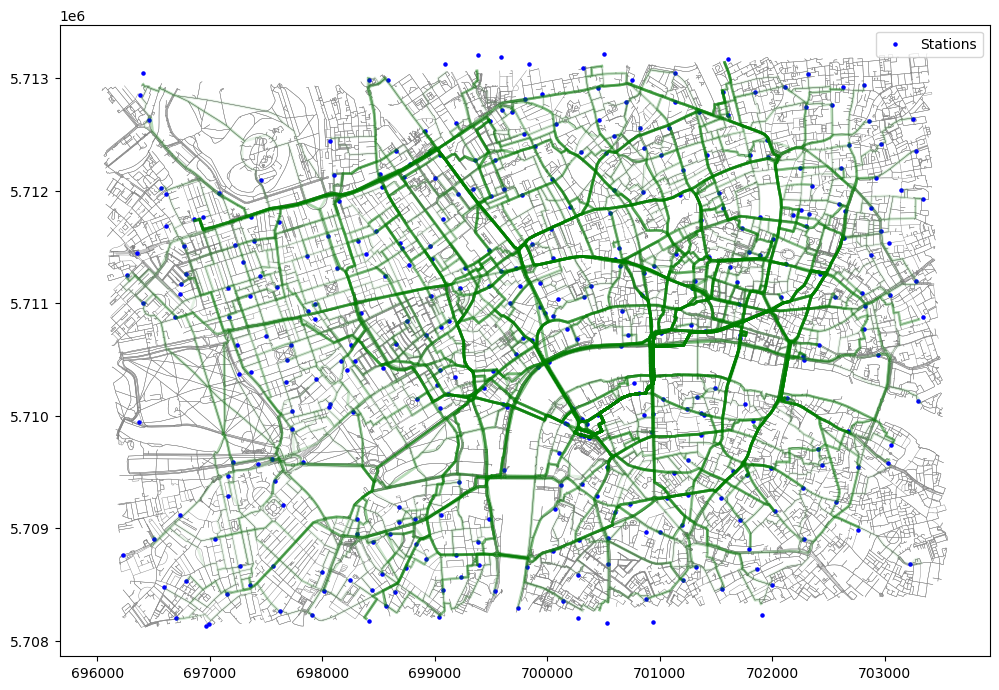

In [23]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the street edges
edges = osm.graph_to_gdfs(central_london, nodes=False, edges=True)
edges.plot(ax=ax, linewidth=0.3, edgecolor='gray')

station_data.plot(ax=ax, color='b', markersize=5, zorder=2, label='Stations'), 

# Plot the paths

for path in od_paths['N']:
    if path:
        # Check if all nodes in path exist in the graph to avoid errors
        if all(node in central_london.nodes for node in path):
            # Get the x and y coordinates for each node in the path
            x_coords = [central_london.nodes[node]['x'] for node in path]
            y_coords = [central_london.nodes[node]['y'] for node in path]

            # Plot the path
            ax.plot(x_coords, y_coords, c='green', linewidth=2, zorder=3, alpha=0.1)

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()

## (02) Heatmap of the most requently visited bicycle stations

In [25]:
# For every station, find the number of occurences in the trips dataframe, it can be as a start or end station
station_data['start_count'] = station_data['commonName'].map(trip_data['Start station'].value_counts())
station_data['end_count'] = station_data['commonName'].map(trip_data['End station'].value_counts()) 
station_data['count'] = station_data['start_count'] + station_data['end_count']
station_data = station_data.sort_values(by='count', ascending=False)
station_data


,commonName,lat,lon,NbDocks,geometry,start_count,end_count,count
118,"Waterloo Station 3, Waterloo",51.503791,-0.112824,35,POINT (700371.135 5709803.412),11583,12136,23719
257,"Waterloo Station 1, Waterloo",51.504027,-0.113864,36,POINT (700297.937 5709826.803),7174,6881,14055
11,"Argyle Street, Kings Cross",51.529416,-0.123944,45,POINT (699487.506 5712622.057),6404,6471,12875
157,"Wormwood Street, Liverpool Street",51.516154,-0.082422,16,POINT (702425.805 5711261.649),5888,5601,11489
140,"Hop Exchange, The Borough",51.504627,-0.091773,56,POINT (701828.105 5709954.226),3830,5110,8940
...,...,...,...,...,...,...,...,...
159,"Knightsbridge, Hyde Park",51.502757,-0.155349,43,POINT (697424.903 5709572.839),440,182,622
178,"Royal Avenue 1, Chelsea",51.489932,-0.162727,10,POINT (696968.252 5708127.038),270,292,562
366,"Upper Grosvenor Street, Mayfair",51.510130,-0.155757,18,POINT (697364.716 5710391.488),171,190,361
170,"Colombo Street, Southwark",51.505459,-0.105692,14,POINT (700858.665 5710008.421),173,157,330


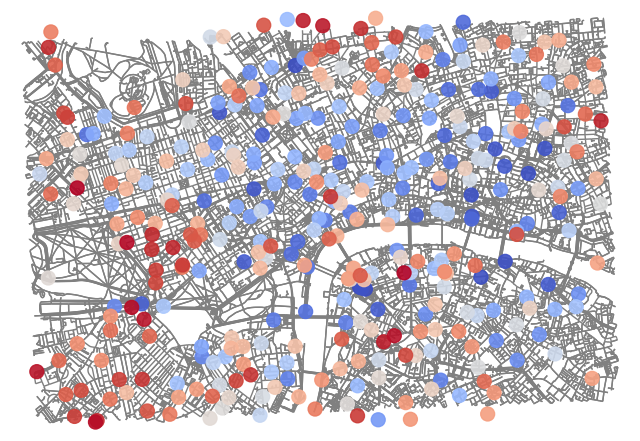

In [26]:
# Plot the stations according to 'count' column, the more the count, the bigger the point
fig, ax = osm.plot_graph(central_london, node_size=3, bgcolor="none", edge_color="grey", node_color="none", show=False, close=False)

#bikestations.plot(ax=ax, markersize =bikestations['count'] / 10 , alpha=0.4, cmap='coolwarm')
station_data.plot(ax=ax, markersize=100 , alpha=0.9, cmap='coolwarm')
plt.axis('off')
plt.show()

## (3) Analze demand patterns

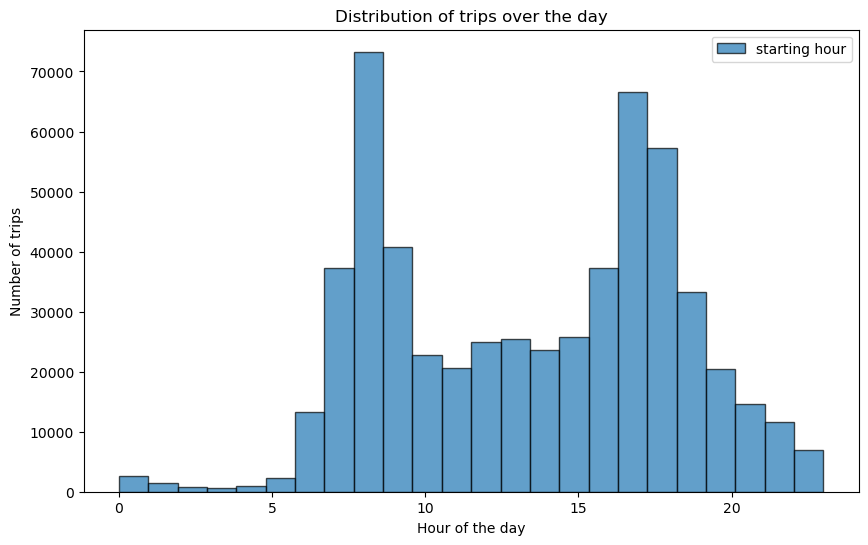

In [28]:
trip_data['starting_hour'] = trip_data['Start date'].dt.hour
trip_data['ending_hour'] = trip_data['End date'].dt.hour

# visualize the distribution of trips over the day
plt.figure(figsize=(10, 6))
plt.hist(trip_data['starting_hour'], bins=24, alpha=0.7, edgecolor='black', label='starting hour')
#plt.hist(cleaned_trip_data['ending_hour'], bins=24, alpha=0.7, label='ending hour')
plt.xlabel('Hour of the day')
plt.ylabel('Number of trips')
plt.title('Distribution of trips over the day')
plt.legend()
plt.show()